In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv("res/train.csv", usecols=['pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                          'dropoff_longitude', 'dropoff_latitude',  'trip_duration'])

In [9]:
df.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435


In [10]:
#Finding what is max and min pickup and dropoff cords

max_pickup_longitude = np.max(df["pickup_longitude"])
min_pickup_longitude = np.min(df["pickup_longitude"])

max_pickup_latitdude = np.max(df["pickup_latitude"])
min_pickup_latitude =  np.min(df["pickup_latitude"])

max_dropoff_longitude = np.max(df["dropoff_longitude"])
min_dropoff_longitude = np.min(df["dropoff_longitude"])

max_dropoff_latitdude = np.max(df["dropoff_latitude"])
min_dropoff_latitude =  np.min(df["dropoff_latitude"])

print(max_pickup_longitude, min_pickup_longitude)
print(max_pickup_latitdude, min_pickup_latitude)

print(max_dropoff_longitude, min_dropoff_latitude)
print(max_dropoff_latitdude, min_dropoff_latitude)



-61.33552932739258 -121.93334197998048
51.88108444213867 34.35969543457031
-61.33552932739258 32.1811408996582
43.92102813720703 32.1811408996582


In [11]:
from bokeh.plotting import figure, show

In [12]:
NYC = x_range, y_range = ((-74.05, -73.7), (40.6, 40.9))

plot_width = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan, wheel_zoom, reset', plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
              x_range=x_range, y_range=y_range, outline_line_color=None,
              min_border=0, min_border_left=0, min_border_right=0,
              min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

options = dict(line_color=None, fill_color='blue', size=5)

In [23]:
samples = df.sample(n=10000)
p = base_plot()

p.circle(x=samples['pickup_longitude'], y=samples['pickup_latitude'], **options)

Figure(id='1478', ...)
CPU times: total: 156 ms
Wall time: 133 ms


In [14]:
samples = df.sample(n=10000)
p = base_plot()

p.circle(x=samples['dropoff_longitude'], y=samples['dropoff_latitude'], **options)
show(p)

CPU times: total: 359 ms
Wall time: 570 ms


In [15]:
import datashader as ds
from datashader import transfer_functions as tr_fns
from datashader.colors import Greys9
Greys9_r = list(reversed(Greys9))[:2]

CPU times: total: 2.08 s
Wall time: 2.56 s


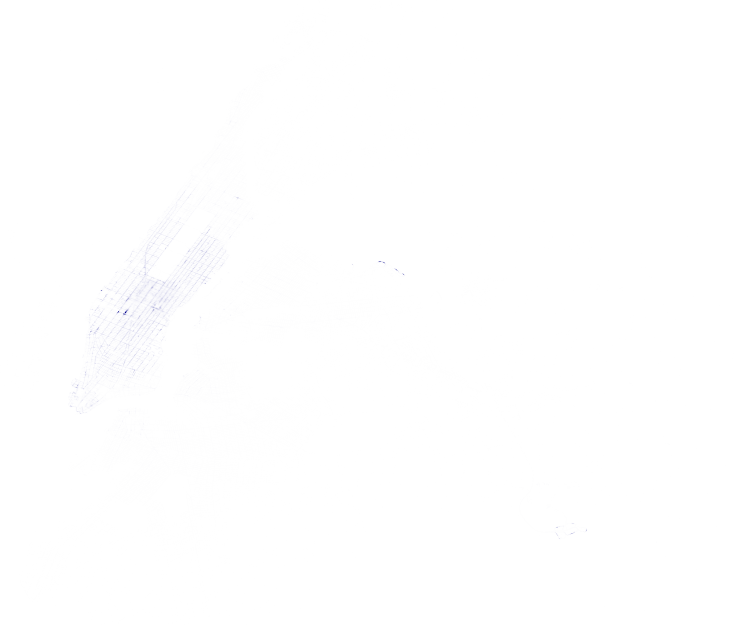

In [16]:
%%time
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'dropoff_longitude', 'dropoff_latitude', ds.count('passenger_count'))
img = tr_fns.shade(agg, cmap=["white", 'darkblue'], how='linear')

img

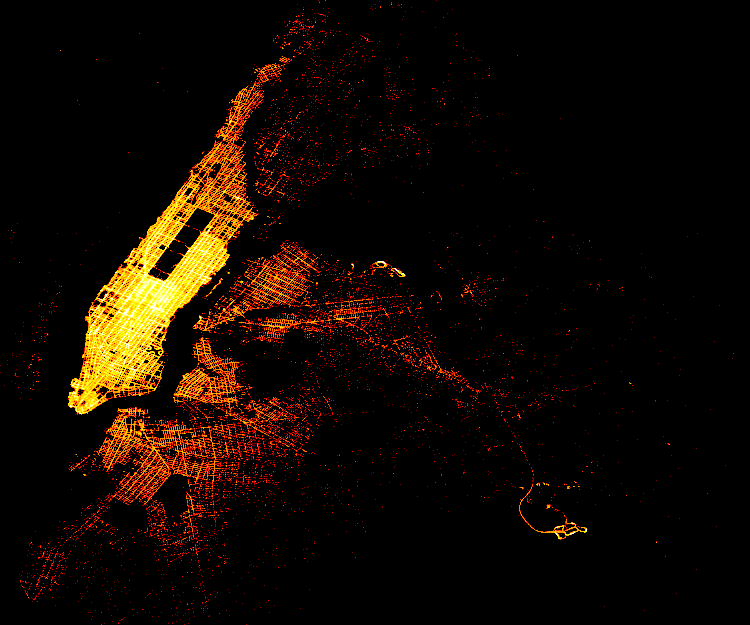

In [17]:
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'dropoff_longitude', 'dropoff_latitude', ds.count('passenger_count'))
    img = tr_fns.shade(agg, cmap=Hot, how='eq_hist')
    return tr_fns.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(*NYC), "NYCT_hot")


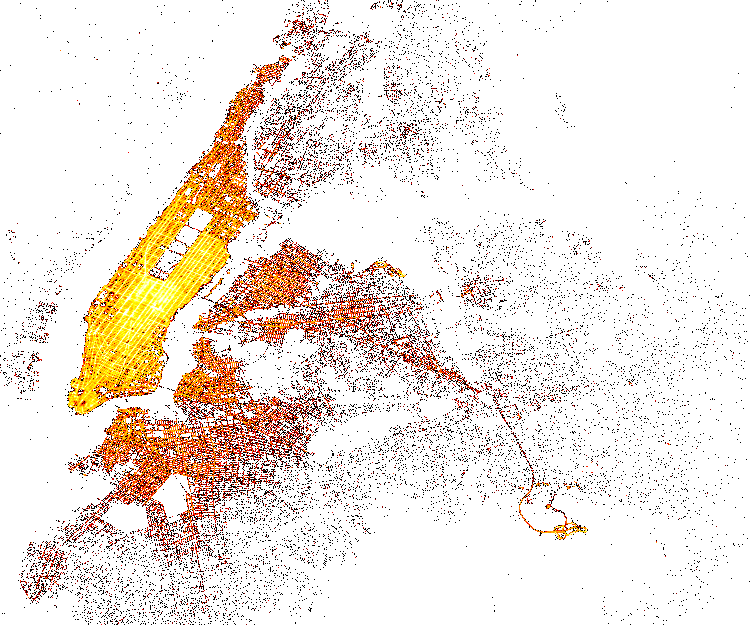

In [18]:
from functools import partial

background = "white"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="white"))
def create_image90(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'pickup_longitude', 'pickup_latitude', ds.count('passenger_count'))
    img = tr_fns.shade(agg.where(agg > np.percentile(agg, 90)), cmap=inferno, how='eq_hist')
    return tr_fns.dynspread(img, threshold=0.3, max_px=4)
    
p = base_plot()
export(create_image(*NYC), "NYCT_90th")


<AxesSubplot:>

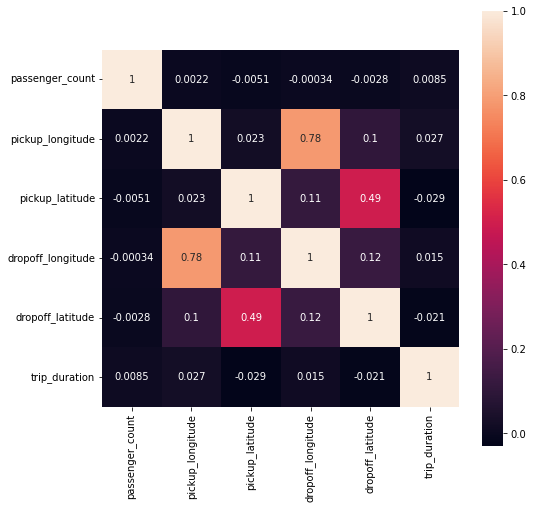

In [25]:
numtrain = df.select_dtypes(include=[np.number])
corr = numtrain.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr,vmax=1,square=True,annot=True)

In [29]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df.pickup_datetime.dt.hour
df['pickup_week'] = df.pickup_datetime.dt.weekday
df['pickup_month'] = df.pickup_datetime.dt.month
df['pickup_day'] = df.pickup_datetime.dt.day

In [30]:
df['pickup_hour'] = df['pickup_hour'].apply(int)
df['pickup_hour'] = df['pickup_hour'].apply(int)

df['pickup_day'] = df['pickup_day'].apply(int)
df['pickup_day'] = df['pickup_day'].apply(int)

df['pickup_month'] = df['pickup_month'].apply(int)
df['pickup_month'] = df['pickup_month'].apply(int)

Text(0, 0.5, 'trip_duration')

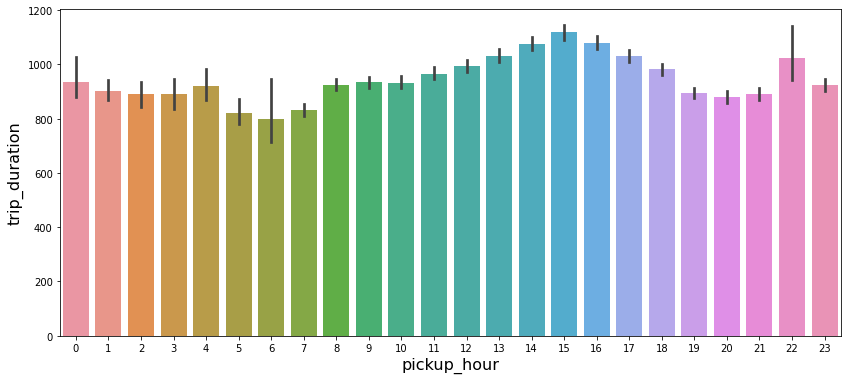

In [63]:
plt.figure(figsize=(14,6))
sns.barplot(x='pickup_hour',y='trip_duration',data=df)
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('trip_duration',fontsize=16)

<AxesSubplot:>

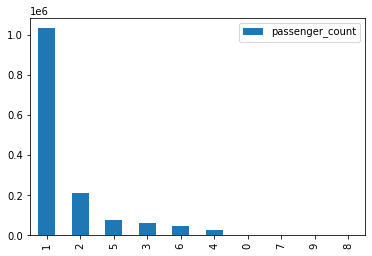

In [65]:
pd.DataFrame(df['passenger_count'].value_counts()).plot(kind='bar')

In [ ]:
#zmienic wykresy, zeby te 2 sie pokazywaly pod kodem, dodac jeszcze jakies, naprawic zeby ten porównawczy działał, naipsac prace